In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

from numpy.random import uniform, seed
from scipy.interpolate import griddata

from matplotlib.font_manager import FontProperties
from sklearn.metrics import roc_curve

In [2]:
inchpad = 0.4

# Prediction with BoostedTrees classifier

Boilerplate code for plotting

In [3]:

def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
  TOP_N = 8 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(xvalid.iloc[ID][sorted_ix], ax)
  return ax

In [4]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    eval_input_fn = make_input_fn(X,
                                  y=y,
                                  shuffle=False,
                                  n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']



We load the hotel cancellations data available from: 
https://www.kaggle.com/jessemostipak/hotel-booking-demand

In [5]:
xtrain = pd.read_csv('../input/hotel-booking-demand/hotel_bookings.csv')
xtrain.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02


In [6]:
xtrain.tail(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07
119389,City Hotel,0,205,2017,August,35,29,2,7,2,...,No Deposit,9.0,NaN,0,Transient,151.20,0,2,Check-Out,2017-09-07


The dataset has a time dimension, so a natural training / validation split can be on `reservation_status_date`:

In [7]:
xvalid = xtrain.loc[xtrain['reservation_status_date'] >= '2017-08-01']
xtrain = xtrain.loc[xtrain['reservation_status_date'] < '2017-08-01']

In [8]:
ytrain, yvalid = xtrain['is_canceled'], xvalid['is_canceled']
xtrain.drop('is_canceled', axis = 1, inplace = True)
xvalid.drop('is_canceled', axis = 1, inplace = True)


We separate the columns into numerical and categorical ones and encode them in the TF-expected format. We skip some columns that could perhaps improve the model performance, but due to their nature they introduce a risk of leakage:
* arrival_date_year 
* assigned_room_type 
* booking_changes
* reservation_status 
* country,
* days_in_waiting_list



In [9]:
xtrain.drop(['arrival_date_year','assigned_room_type', 'booking_changes', 'reservation_status',
             'country', 'days_in_waiting_list'], axis =1, inplace = True)

In [10]:
num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

In [11]:
def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in cat_features:
    # Need to one-hot encode categorical features.
    vocabulary = xtrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in num_features:
    feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))

The next required step is creating the input functions for BoostedTrees algorithm: we specify how data will be read into our model for both training and inference. We use the `from_tensor_slices` method in the tf.data API to read in data directly from Pandas. 

In [12]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(ytrain)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    
    def input_fn():
        
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn


# Training and evaluation input functions.
train_input_fn = make_input_fn(xtrain, ytrain)
eval_input_fn = make_input_fn(xvalid, yvalid, shuffle=False, n_epochs=1)

Build the actual BoostedTrees model

In [13]:
params = {
  'n_trees': 125,
  'max_depth': 5,
  'n_batches_per_layer': 1,
#   'learning_rate': 0.05, 
#   'l1_regularization': 0.00001, 
#   'l2_regularization': 0.00001,
#    'min_node_weight': 0.01,
  # You must enable center_bias = True to get DFCs. This will force the model to
  # make an initial prediction before using any features (e.g. use the mean of
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}


est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation
results = est.evaluate(eval_input_fn)
pd.Series(results).to_frame()

,0
accuracy,0.734383
accuracy_baseline,0.916010
auc,0.652860
auc_precision_recall,0.200550
average_loss,0.533693
label/mean,0.083990
loss,0.533693
precision,0.134249
prediction/mean,0.357677
recall,0.396875


In [14]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])


We can evaluate the results at different levels of generality. Let's start with the ROC curve.

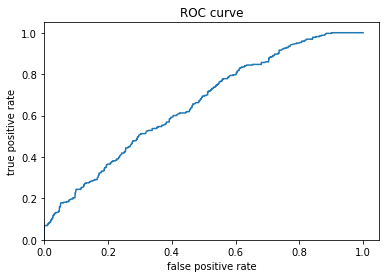

In [15]:
fpr, tpr, _ = roc_curve(yvalid, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,); plt.ylim(0,); plt.show()

`Local interpretability` refers to an understanding of a model’s predictions at the individual example level: we will create and visualize per-instance contributions. To distinguish this from feature importances, we refer to these values as directional feature contributions (DFCs).

In [16]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

# Create DFC Pandas dataframe.
labels = yvalid.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,3810.0,-0.000682,0.063035,-0.202496,-0.027492,0.008910,0.040918,0.129666
arrival_date_week_number,3810.0,0.018455,0.023207,-0.031759,0.004746,0.012216,0.018577,0.144226
arrival_date_day_of_month,3810.0,0.015650,0.025674,-0.016337,0.001810,0.003945,0.012878,0.094999
agent,3810.0,0.003016,0.017426,-0.061667,-0.008859,-0.000686,0.013282,0.108473
market_segment,3810.0,-0.005189,0.041567,-0.193779,-0.043245,0.002045,0.019084,0.116374
arrival_date_month,3810.0,0.015526,0.014650,-0.034951,0.005684,0.015046,0.030692,0.125894
previous_cancellations,3810.0,-0.022099,0.019902,-0.072509,-0.033536,-0.026191,-0.007309,0.282636
adr,3810.0,0.015311,0.019415,-0.041114,0.000939,0.011563,0.025249,0.134645
deposit_type,3810.0,-0.022877,0.013779,-0.070087,-0.024956,-0.023430,-0.021947,0.152358
customer_type,3810.0,-0.000542,0.034502,-0.131497,-0.006719,0.006467,0.015470,0.133783


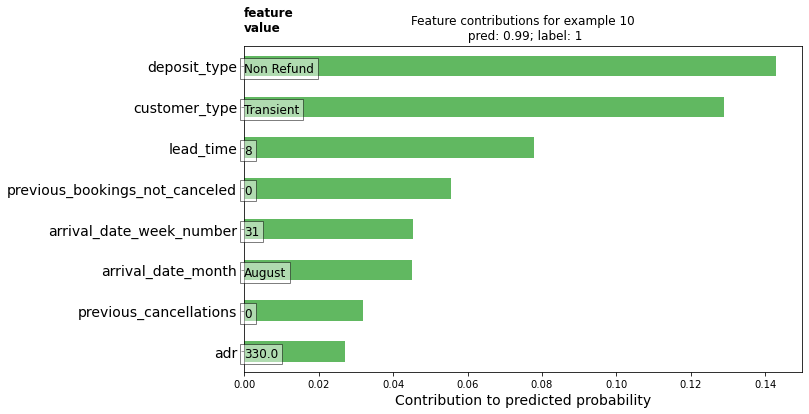

In [17]:
# Plot results.
ID = 10
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)

plt.savefig('B16254_05_04_KB300.png', dpi = 300, bbox_inches = "tight")
plt.savefig('B16254_05_04_KB450.png', dpi = 450, bbox_inches = "tight")
plt.savefig('B16254_05_04_KB600.png', dpi = 600, bbox_inches = "tight")

plt.show()

`Global interpretability` refers to an understanding of the model as a whole: we will retrieve and visualize gain-based feature importances, permutation feature importances and also show aggregated DFCs.



Gain-based feature importances using est.experimental_feature_importances
Permutation importances
Aggregate DFCs using est.experimental_predict_with_explanations
Gain-based feature importances measure the loss change when splitting on a particular feature, while permutation feature importances are computed by evaluating model performance on the evaluation set by shuffling each feature one-by-one and attributing the change in model performance to the shuffled feature.

In general, permutation feature importance are preferred to gain-based feature importance, though both methods can be unreliable in situations where potential predictor variables vary in their scale of measurement or their number of categories and when features are correlated (source). 

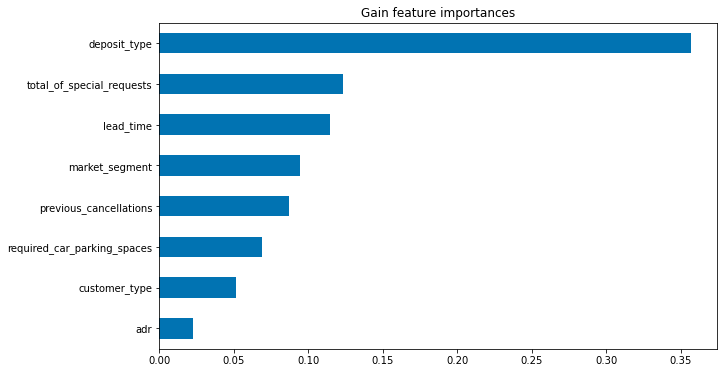

In [18]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

plt.savefig('B16254_05_06_KB300.png', dpi = 300, bbox_inches = "tight")
plt.savefig('B16254_05_06_KB450.png', dpi = 450, bbox_inches = "tight")
plt.savefig('B16254_05_06_KB600.png', dpi = 600, bbox_inches = "tight")


Absolute values of DFCs can be averaged to understand impact at a global level.

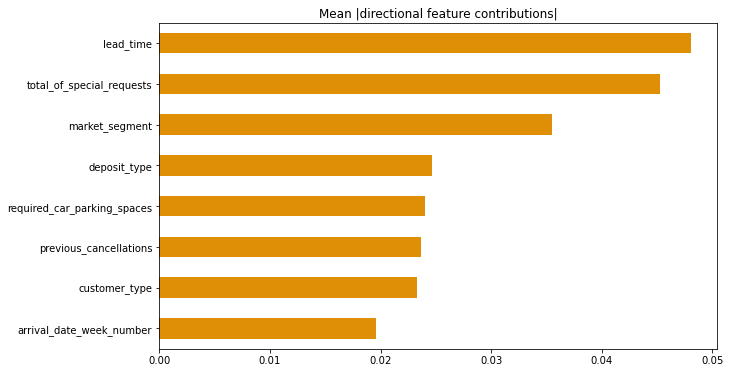

In [19]:
# Plot.
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  # Average and sort by absolute.
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')




plt.savefig('B16254_05_07_KB300.png', dpi = 300, bbox_inches = "tight")
plt.savefig('B16254_05_07_KB450.png', dpi = 450, bbox_inches = "tight")
plt.savefig('B16254_05_07_KB600.png', dpi = 600, bbox_inches = "tight")

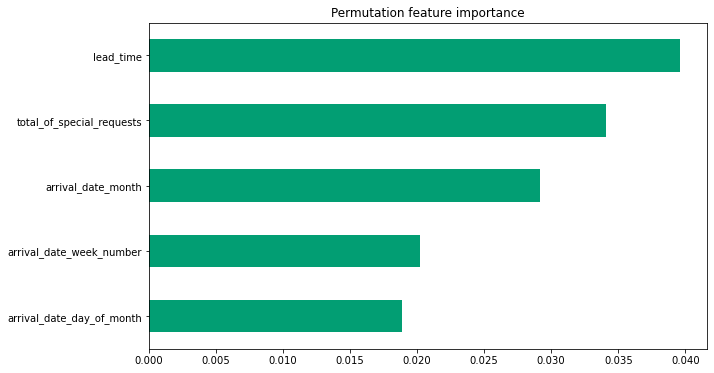

In [20]:
features = cat_features + num_features
importances = permutation_importances(est, xvalid, yvalid, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')

plt.savefig('B16254_05_05_KB300.png', dpi = 300, bbox_inches = "tight")
plt.savefig('B16254_05_05_KB450.png', dpi = 450, bbox_inches = "tight")
plt.savefig('B16254_05_05_KB600.png', dpi = 600, bbox_inches = "tight")

plt.show()